In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

from datetime import datetime
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

from helper_functions import *

In [2]:
from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()
start_all = datetime.now()

In [3]:
emo_train_df = pd.read_csv('data/2018-E-c-En-train.txt', sep='\t')
emo_test_df = pd.read_csv('data/2018-E-c-En-test-gold.txt', sep='\t')
print(emo_train_df.shape)
emo_train_df.head()

(6838, 13)


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Data exploration

Class distribution

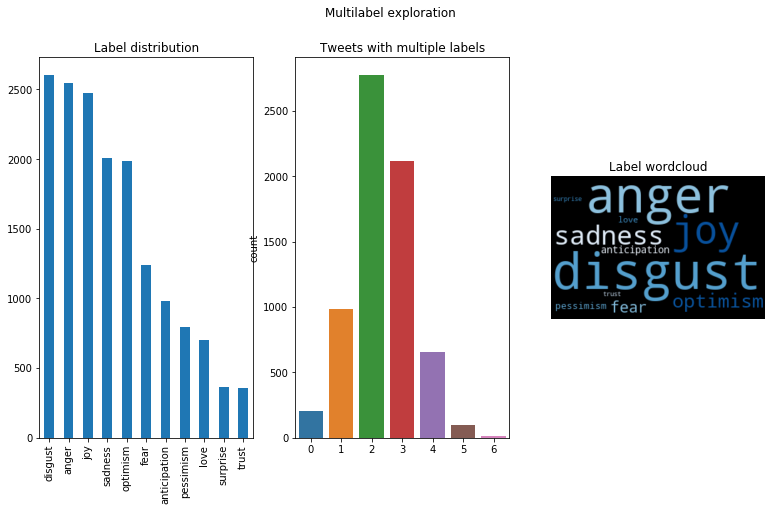

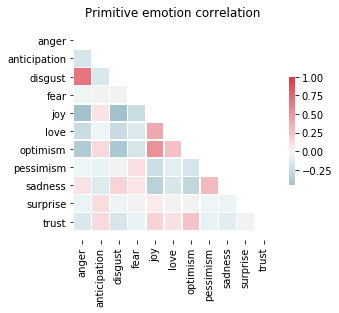

In [4]:
feelings = emo_train_df.columns[2:]#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
multilabel_visualization(emo_train_df[feelings].values, feelings)

Preprocessing test and train sets:
* Tokenization
* Stopword removal
* Special character handling
* Emoji parsing
* Data cleaning

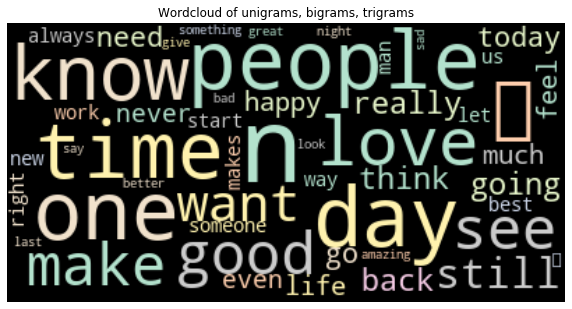

In [5]:
# preprocessing test and training sets
combined_df = pd.concat([emo_train_df, emo_test_df])
combined_df['tokenized_features'] = combined_df['Tweet'].apply(tweet_processor.tweet_pipeline)

corpus = combined_df['tokenized_features'].apply(lambda x: ' '.join(x))
draw_wordcloud(corpus)

## Feature selection

In [6]:
# Tweet preprocessing
combined_df['tokenized_features'] = combined_df['Tweet'].apply(tweet_processor.tweet_pipeline)
X = combined_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)


/home/arvartho/python/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


 Dataset split

In [7]:
# Combine features
X_combined = np.hstack((X_tfidf.toarray(), X_emoji.toarray()))
emo_train_df['feature_vector'] = X_combined[:emo_train_df.shape[0]].tolist()
emo_test_df['feature_vector'] = X_combined[-emo_test_df.shape[0]:].tolist()
emo_train_df['feature_vector'].shape, emo_test_df['feature_vector'].shape

x_train = np.vstack(emo_train_df['feature_vector'].values)
x_test = np.vstack(emo_test_df['feature_vector'].values)
y_train = emo_train_df[feelings].values
y_test = emo_test_df[feelings].values

x_train.shape, y_train.shape, x_test.shape

((6838, 4824), (6838, 11), (3259, 4824))

## Classification

One-vs-rest classification

In [8]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline


print("")
print("Starting classifier...")
print("")
start = datetime.now()

pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB(class_prior=None)))
            ])

parameters = [{
            'clf__estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, 
                              parameters, 
                              cv=2,
                              verbose=2,
                              n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 

y_pred = best_clf.predict(x_test)
start = datetime.now()
print(multilabel_evaluation(y_pred, y_test))
# print(best_clf.get_params())
print('Finished classification in : ', datetime.now()-start) 
best_clf.get_params()


Starting classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   57.1s remaining:   57.1s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   58.6s finished


Finished training in :  0:01:17.556734
{'accuracy': 0.845, 'precision': 0.371, 'recall': 0.528, 'f1_score': 0.436, 'hamming_loss': 0.155}
Finished classification in :  0:00:00.051975


{'memory': None,
 'steps': [('clf', OneVsRestClassifier(estimator=BernoulliNB(alpha=0.5)))],
 'verbose': False,
 'clf': OneVsRestClassifier(estimator=BernoulliNB(alpha=0.5)),
 'clf__estimator__alpha': 0.5,
 'clf__estimator__binarize': 0.0,
 'clf__estimator__class_prior': None,
 'clf__estimator__fit_prior': True,
 'clf__estimator': BernoulliNB(alpha=0.5),
 'clf__n_jobs': None}

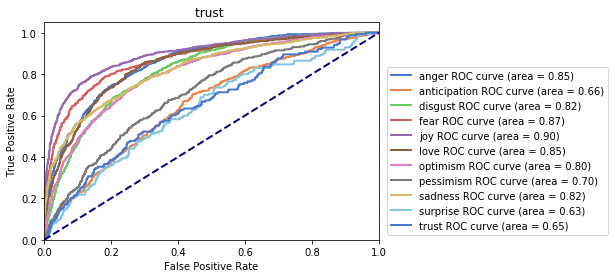

In [9]:
# Plot ROC curve for every label
plot_roc(y_test, best_clf.predict_proba(x_test), feelings.values)

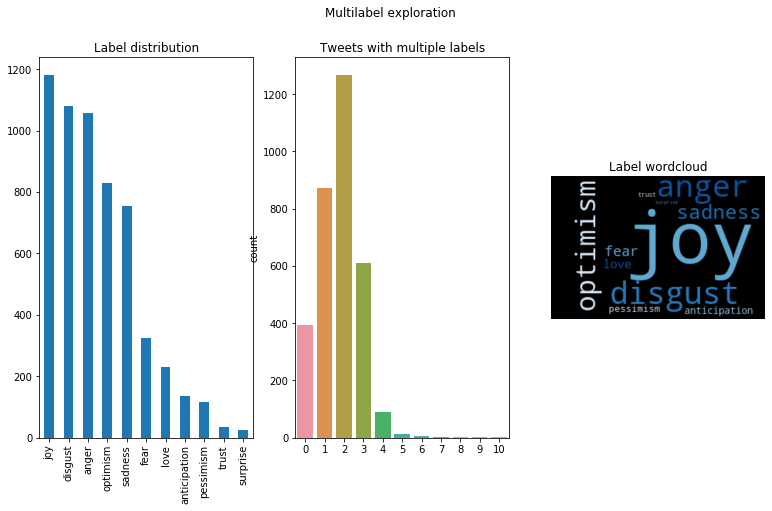

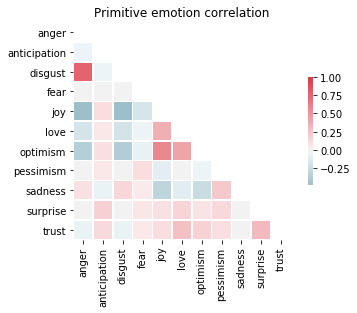

In [15]:
multilabel_visualization(y_pred, feelings)

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

print("")
print("Starting OneVsRestClassifier MultinomialNB classifier...")
print("")
start = datetime.now()

parameters = [{
            'estimator__alpha': (0.5, 0.7, 1),
            }]

grid_search_cv = GridSearchCV(OneVsRestClassifier(MultinomialNB(class_prior=None)), 
                              parameters, 
                              cv=2,
                              verbose=1,
                             n_jobs=-1)
grid_search_cv.fit(x_train, y_train)
best_clf = grid_search_cv.best_estimator_

print('Finished training in : ', datetime.now()-start) 
start = datetime.now()
y_pred = best_clf.predict(x_test)
print(multilabel_evaluation(y_pred, y_test))
# print(best_clf.get_params())
print('Finished classification in : ', datetime.now()-start) 



Starting OneVsRestClassifier MultinomialNB classifier...

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    3.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.1s finished


Finished training in :  0:00:03.731032
{'accuracy': 0.843, 'precision': 0.263, 'recall': 0.677, 'f1_score': 0.379, 'hamming_loss': 0.157}
Finished classification in :  0:00:00.179806


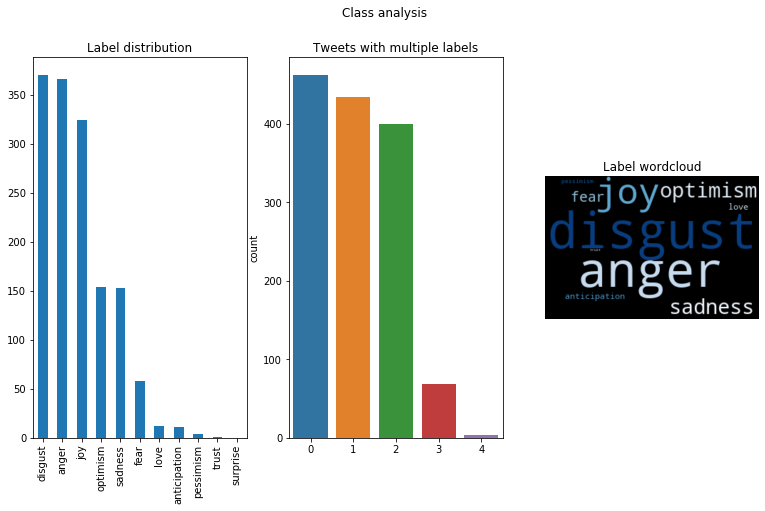

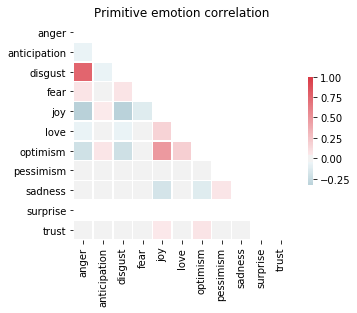

In [17]:
multilabel_visualization(y_pred, feelings)

In [13]:
print('Finished training in : ', datetime.now()-start_all)

Finished training in :  0:00:34.530155
